# NEURODATA MRI TO GRAPHS (NDMG)

## Setup Steps

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Standard Library
import os
import shutil
import time
from datetime import datetime
from subprocess import Popen

# External Packages
import numpy as np
import nibabel as nib
from dipy.tracking.streamline import Streamlines

# Internal Imports
import ndmg
from ndmg import preproc as mgp
from ndmg.utils import gen_utils as mgu
from ndmg import register as mgr
from ndmg.track import track as mgt
from ndmg.graph import graph as mgg
from ndmg.utils.bids_utils import NameResource

# Inputs
dwi = '/mnt/labbook/input/data/BNU1/sub-0025864/ses-1/dwi/sub-0025864_ses-1_dwi.nii.gz'
bvals = '/mnt/labbook/input/data/BNU1/sub-0025864/ses-1/dwi/sub-0025864_ses-1_dwi.bval'
bvecs = '/mnt/labbook/input/data/BNU1/sub-0025864/ses-1/dwi/sub-0025864_ses-1_dwi.bvec'
t1w = '/mnt/labbook/input/data/BNU1/sub-0025864/ses-1/anat/sub-0025864_ses-1_T1w.nii.gz'
atlas = 'desikan'
mask = '/ndmg_atlases/atlases/mask/MNI152NLin6_res-2x2x2_T1w_descr-brainmask.nii.gz'
labels = ['/ndmg_atlases/atlases/label/Human/desikan_space-MNI152NLin6_res-2x2x2.nii.gz']
outdir = '/mnt/labbook/output/untracked'
vox_size = '2mm'
mod_type = 'det'
track_type = 'local'
mod_func = 'csa'
seed_dens = 1
reg_style = 'native'
clean = False
skipeddy=False,
skipreg=False,
buck=None,
remo=None,
push=False,
creds=None,
debug=False,
modif="",

assert all(map(os.path.exists, [dwi, bvals, bvecs, t1w, mask, labels[0], outdir]))

"""Creates a brain graph from MRI data

Parameters
----------
dwi : str
    Path for the dwi file(s)
bvals : str
    Path for the bval file(s)
bvecs : str
    Path for the bvec file(s)
t1w : str
    Location of anatomical input file(s)
atlas : str
    Location of atlas file
mask : str
    Location of T1w brain mask file, make sure the proper voxel size is used
labels : list
    Location of file containing the labels for the atlas file(s)
outdir : str
    The directory where the output files should be stored. Prepopulate this folder with results of participants level analysis if running gorup analysis.
vox_size : str
    Voxel size to use for template registrations. Default is '2mm'.
mod_type : str
    Determinstic (det) or probabilistic (prob) tracking. Default is det.
track_type : str
    Tracking approach: eudx or local. Default is eudx.
mod_func : str
    Diffusion model: csd, csa, or tensor. Default is tensor.
seeds : int
    Density of seeding for native-space tractography.
reg_style : str
    Space for tractography. Default is native.
clean : bool
    Whether or not to delete intermediates. Default is False.
skipeddy : bool
    Whether or not to skip the eddy correction if it has already been run. Default is False.
skipreg : bool
    Whether or not to skip registration. Default is False.
buck : str, optional
    The name of an S3 bucket which holds BIDS organized data. You musht have build your bucket with credentials to the S3 bucket you wish to access. Default is None
remo : str, optional
    The path to the data on your S3 bucket. The data will be downloaded to the provided bids_dir on your machine. Default is None.
push : bool, optional
    Flag to push derivatives back to S3. Default is False
creds : bool, optional
    Determine if you have S3 credentials. Default is True
debug : bool, optional
    If False, remove any old filed in the output directory. Default is False
modif : str, optional
    Name of the folder on s3 to push to. If empty, push to a folder with ndmg's version number. Default is ""

Raises
------
ValueError
    Raised if downsampling voxel size is not supported
ValueError
    Raised if bval/bvecs are potentially corrupted
"""
print("dwi = {}".format(dwi))
print("bvals = {}".format(bvals))
print("bvecs = {}".format(bvecs))
print("t1w = {}".format(t1w))
print("atlas = {}".format(atlas))
print("mask = {}".format(mask))
print("labels = {}".format(labels))
print("outdir = {}".format(outdir))
print("vox_size = {}".format(vox_size))
print("mod_type = {}".format(mod_type))
print("track_type = {}".format(track_type))
print("mod_func = {}".format(mod_func))
print("seed density = {}".format(seed_dens))
print("reg_style = {}".format(reg_style))
print("clean = {}".format(clean))
print("skip eddy = {}".format(skipeddy))
print("skip registration = {}".format(skipreg))
fmt = "_adj.csv"

assert all(
    [
        dwi,
        bvals,
        bvecs,
        t1w,
        atlas,
        mask,
        labels,
        outdir,
        vox_size,
        mod_type,
        track_type,
        mod_func,
        seed_dens,
        reg_style,
    ]
), "Missing a default argument."

namer = NameResource(dwi, t1w, atlas, outdir)

# TODO : do this with shutil instead of an os command
print("Output directory: " + outdir)
if not os.path.isdir(outdir):
    cmd = "mkdir -p {}".format(outdir)
    subprocess.run(cmd, shell=True, check=True)

paths = {
    "prep_dwi": "dwi/preproc",
    "prep_anat": "anat/preproc",
    "reg_anat": "anat/registered",
    "fiber": "dwi/fiber",
    "tensor": "dwi/tensor",
    "conn": "dwi/roi-connectomes"
}

label_dirs = ["conn"]  # create label level granularity

print("Adding directory tree...")
namer.add_dirs_dwi(paths, labels, label_dirs)

# Create derivative output file names
streams = namer.name_derivative(namer.dirs["output"]["fiber"], "streamlines.trk")

# Again, connectomes are different
if not isinstance(labels, list):
    labels = [labels]
connectomes = [
    namer.name_derivative(
        namer.dirs["output"]["conn"][namer.get_label(lab)],
        "{}_{}_measure-spatial-ds{}".format(
            namer.get_mod_source(), namer.get_label(lab), fmt
        ),
    )
    for lab in labels
]

print("Connectomes downsampled to given labels: " + ", ".join(connectomes))

if vox_size != "1mm" and vox_size != "2mm":
    raise ValueError("Voxel size not supported. Use 2mm or 1mm")
print('DONE')

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


dwi = /mnt/labbook/input/data/BNU1/sub-0025864/ses-1/dwi/sub-0025864_ses-1_dwi.nii.gz
bvals = /mnt/labbook/input/data/BNU1/sub-0025864/ses-1/dwi/sub-0025864_ses-1_dwi.bval
bvecs = /mnt/labbook/input/data/BNU1/sub-0025864/ses-1/dwi/sub-0025864_ses-1_dwi.bvec
t1w = /mnt/labbook/input/data/BNU1/sub-0025864/ses-1/anat/sub-0025864_ses-1_T1w.nii.gz
atlas = desikan
mask = /ndmg_atlases/atlases/mask/MNI152NLin6_res-2x2x2_T1w_descr-brainmask.nii.gz
labels = ['/ndmg_atlases/atlases/label/Human/desikan_space-MNI152NLin6_res-2x2x2.nii.gz']
outdir = /mnt/labbook/output/untracked
vox_size = 2mm
mod_type = det
track_type = local
mod_func = csa
seed density = 1
reg_style = native
clean = False
skip eddy = (False,)
skip registration = (False,)
Output directory: /mnt/labbook/output/untracked
Adding directory tree...
Connectomes downsampled to given labels: /mnt/labbook/output/untracked/dwi/roi-connectomes/desikan_space-MNI152NLin6_res-2x2x2/sub-0025864_ses-1_dwi_desikan_space-MNI152NLin6_res-2x2x2_measu

## Preprocessing

### Eddy Correction

In [2]:
# Perform eddy correction
dwi_prep = "{}/eddy_corrected_data.nii.gz".format(namer.dirs["output"]["prep_dwi"])

if len(os.listdir(namer.dirs["output"]["prep_dwi"])) != 0:
    if skipeddy is False:
        try:
            print("Pre-existing preprocessed dwi files found. Deleting these...")
            shutil.rmtree(namer.dirs["output"]["prep_dwi"])
            os.mkdir(namer.dirs["output"]["prep_dwi"])
        except Exception as e:
            print("Exception when trying to delete existing data: {}".format(e))
            pass
        print("Performing eddy correction...")
        cmd = "eddy_correct " + dwi + " " + dwi_prep + " 0"
        print(cmd)
        sts = Popen(cmd, shell=True).wait()
        print(sts)
        ts = time.time()
        st = datetime.fromtimestamp(ts).strftime("%Y-%m-%d %H:%M:%S")
        print(st)
    else:
        if not os.path.isfile(dwi_prep):
            raise ValueError(
                "ERROR: Cannot skip eddy correction if it has not already been run!"
            )
else:
    print("Performing eddy correction...")
    ts = time.time()
    st = datetime.fromtimestamp(ts).strftime("%Y-%m-%d %H:%M:%S")
    print(st)
    cmd = "eddy_correct " + dwi + " " + dwi_prep + " 0"
    print(cmd)
    sts = Popen(cmd, shell=True).wait()
    print(sts)
    print(f"eddy correct time: {time.time() - ts} seconds.")
print('DONE')

Performing eddy correction...
2019-08-22 03:27:19
eddy_correct /mnt/labbook/input/data/BNU1/sub-0025864/ses-1/dwi/sub-0025864_ses-1_dwi.nii.gz /mnt/labbook/output/untracked/dwi/preproc/eddy_corrected_data.nii.gz 0
0
eddy correct time: 59.48024296760559 seconds.
DONE


### Scale and Correct Gradient Files

In [3]:
# Instantiate bvec/bval naming variations and copy to derivative director
bvec_scaled = "{}/bvec_scaled.bvec".format(namer.dirs["output"]["prep_dwi"])
fbval = "{}/bval.bval".format(namer.dirs["output"]["prep_dwi"])
fbvec = "{}/bvec.bvec".format(namer.dirs["output"]["prep_dwi"])
shutil.copyfile(bvecs, fbvec)
shutil.copyfile(bvals, fbval)

# Correct any corrupted bvecs/bvals
from dipy.io import read_bvals_bvecs

bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
bvecs[np.where(np.any(abs(bvecs) >= 10, axis=1) == True)] = [1, 0, 0]
bvecs[np.where(bvals == 0)] = 0
if (
    len(
        bvecs[
            np.where(
                np.logical_and(
                    bvals > 50, np.all(abs(bvecs) == np.array([0, 0, 0]), axis=1)
                )
            )
        ]
    )
    > 0
):
    raise ValueError(
        "WARNING: Encountered potentially corrupted bval/bvecs. Check to ensure volumes with a "
        "diffusion weighting are not being treated as B0's along the bvecs"
    )
np.savetxt(fbval, bvals)
np.savetxt(fbvec, bvecs)
print('DONE')

DONE


## Ndmg Preprocessing: Reorienting / Rescaling

In [4]:
# Rescale bvecs
start_time = time.time()
print("Rescaling b-vectors...")
mgp.rescale_bvec(fbvec, bvec_scaled)

# Check orientation (dwi_prep)
[dwi_prep, bvecs] = mgu.reorient_dwi(dwi_prep, bvec_scaled, namer)
print(
    "%s%s%s"
    % ("Reorienting runtime: ", str(np.round(time.time() - start_time, 1)), "s")
)

# Check dimensions
start_time = time.time()
dwi_prep = mgu.match_target_vox_res(dwi_prep, vox_size, namer, sens="dwi")
print(
    "%s%s%s"
    % ("Reslicing runtime: ", str(np.round(time.time() - start_time, 1)), "s")
)
print('DONE')

Rescaling b-vectors...
Reorienting /mnt/labbook/output/untracked/dwi/preproc/eddy_corrected_data.nii.gz to RAS+...
Reorienting runtime: 0.9s
Reslicing image /mnt/labbook/output/untracked/dwi/preproc/eddy_corrected_data_reor_RAS.nii.gz to 2mm...
Reslicing runtime: 9.7s
DONE


### Build Gradient Table

In [5]:
start_time = time.time()

print("fbval: ", fbval)
print("bvecs: ", bvecs)
print("fbvec: ", fbvec)
print("dwi_prep: ", dwi_prep)
print("namer.dirs: ", namer.dirs["output"]["prep_dwi"])
[gtab, nodif_B0, nodif_B0_mask] = mgu.make_gtab_and_bmask(
    fbval, fbvec, dwi_prep, namer.dirs["output"]["prep_dwi"]
)

# Get B0 header and affine
dwi_prep_img = nib.load(dwi_prep)
hdr = dwi_prep_img.header
print(
    "%s%s%s"
    % ("Preprocessing runtime: ", str(np.round(time.time() - start_time, 1)), "s")
)
print('DONE')

fbval:  /mnt/labbook/output/untracked/dwi/preproc/bval.bval
bvecs:  /mnt/labbook/output/untracked/dwi/preproc/bvecs_reor.bvec
fbvec:  /mnt/labbook/output/untracked/dwi/preproc/bvec.bvec
dwi_prep:  /mnt/labbook/output/untracked/dwi/preproc/eddy_corrected_data_reor_RAS_res.nii.gz
namer.dirs:  /mnt/labbook/output/untracked/dwi/preproc
/mnt/labbook/output/untracked/dwi/preproc/bval.bval
/mnt/labbook/output/untracked/dwi/preproc/bvec.bvec
B0's found at: [0]
B-values shape (16,)
         min 0.000000 
         max 1000.000000 
B-vectors shape (16, 3)
         min -0.978756 
         max 0.941755 
None
Extracting B0's...
0
fslroi /mnt/labbook/output/untracked/dwi/preproc/eddy_corrected_data_reor_RAS_res.nii.gz /mnt/labbook/output/untracked/dwi/preproc/0_B0.nii.gz 0 1
Preprocessing runtime: 27.2s
DONE


## NDMG REGISTRATION

In [6]:
# -------- Registration Steps ----------------------------------- #
if (skipreg is False) and len(os.listdir(namer.dirs["output"]["prep_anat"])) != 0:
    try:
        print("Pre-existing preprocessed t1w files found. Deleting these...")
        shutil.rmtree(namer.dirs["output"]["prep_anat"])
        os.mkdir(namer.dirs["output"]["prep_anat"])
    except:
        pass
if (skipreg is False) and len(os.listdir(namer.dirs["output"]["reg_anat"])) != 0:
    try:
        print("Pre-existing registered t1w files found. Deleting these...")
        shutil.rmtree(namer.dirs["output"]["reg_anat"])
        os.mkdir(namer.dirs["output"]["reg_anat"])
    except:
        pass
if (skipreg is False) and (
    (len(os.listdir(namer.dirs["tmp"]["reg_a"])) != 0)
    or (len(os.listdir(namer.dirs["tmp"]["reg_m"])) != 0)
):
    try:
        print("Pre-existing temporary files found. Deleting these...")
        shutil.rmtree(namer.dirs["tmp"]["reg_a"])
        os.mkdir(namer.dirs["tmp"]["reg_a"])
        shutil.rmtree(namer.dirs["tmp"]["reg_m"])
        os.mkdir(namer.dirs["tmp"]["reg_m"])
    except:
        pass

# Check orientation (t1w)
start_time = time.time()
t1w = mgu.reorient_img(t1w, namer)
t1w = mgu.match_target_vox_res(t1w, vox_size, namer, sens="t1w")
print(
    "%s%s%s"
    % ("Reorienting runtime: ", str(np.round(time.time() - start_time, 1)), "s")
)


print("Running registration in native space...")
# Instantiate registration
reg = mgr.DmriReg(namer, nodif_B0, nodif_B0_mask, t1w, vox_size, simple=False)

# Perform anatomical segmentation
start_time = time.time()
if (skipreg is True) and os.path.isfile(reg.wm_edge):
    print("Found existing gentissue run!")
    pass
else:
    reg.gen_tissue()
    print(
        "%s%s%s"
        % (
            "gen_tissue runtime: ",
            str(np.round(time.time() - start_time, 1)),
            "s",
        )
    )

# Align t1w to dwi
start_time = time.time()
if (
    (skipreg is True)
    and os.path.isfile(reg.t1w2dwi)
    and os.path.isfile(reg.mni2t1w_warp)
    and os.path.isfile(reg.t1_aligned_mni)
):
    print("Found existing t1w2dwi run!")
    pass
else:
    reg.t1w2dwi_align()
    print(
        "%s%s%s"
        % (
            "t1w2dwi_align runtime: ",
            str(np.round(time.time() - start_time, 1)),
            "s",
        )
    )

# Align tissue classifiers
start_time = time.time()
if (
    (skipreg is True)
    and os.path.isfile(reg.wm_gm_int_in_dwi)
    and os.path.isfile(reg.vent_csf_in_dwi)
    and os.path.isfile(reg.corpuscallosum_dwi)
):
    print("Found existing tissue2dwi run!")
    pass
else:
    reg.tissue2dwi_align()
    print(
        "%s%s%s"
        % (
            "tissue2dwi_align runtime: ",
            str(np.round(time.time() - start_time, 1)),
            "s",
        )
    )
print('DONE')

Reorienting /mnt/labbook/input/data/BNU1/sub-0025864/ses-1/anat/sub-0025864_ses-1_T1w.nii.gz to RAS+...
Reslicing image /mnt/labbook/output/untracked/anat/preproc/sub-0025864_ses-1_T1w_reor_RAS.nii.gz to 2mm...
Reorienting runtime: 1.4s
Running registration in native space...
Extracting brain from raw T1w image...
Executing: 3dSkullStrip -prefix /mnt/labbook/output/untracked/anat/preproc/t1w_brain.nii.gz -input /mnt/labbook/output/untracked/anat/preproc/sub-0025864_ses-1_T1w_reor_RAS_res.nii.gz
Segmenting Anatomical Image into WM, GM, and CSF with FSL's FAST:
Executing fast: fast -t 1  -n 3 -o /mnt/labbook/output/untracked/anat/preproc/t1w_seg /mnt/labbook/output/untracked/anat/preproc/t1w_brain.nii.gz
Reslicing image /mnt/labbook/output/untracked/anat/preproc/t1w_brain.nii.gz to 2mm...
Reslicing image /mnt/labbook/output/untracked/anat/preproc/t1w_seg_pve_2.nii.gz to 2mm...
Reslicing image /mnt/labbook/output/untracked/anat/preproc/t1w_seg_pve_1.nii.gz to 2mm...
Reslicing image /mnt/l

## Reconstruction and Tractography

### Seeding and Streamline Generation

In [7]:
start_time = time.time()
seeds = mgt.build_seed_list(reg.wm_gm_int_in_dwi, np.eye(4), dens=int(seed_dens))
print("Using " + str(len(seeds)) + " seeds...")

### Fit Diffusion Model (to get directions), and track.

# Compute direction model and track fiber streamlines
from dipy.tracking.streamline import Streamlines
from dipy.tracking.local import BinaryStoppingCriterion
from dipy.reconst.shm import CsaOdfModel    
from dipy.tracking.local import LocalTracking
from dipy.data import get_sphere
from dipy.direction import ProbabilisticDirectionGetter
import tempfile
tempfile.tempdir = '/tmp'

dwi = dwi_prep
gm_in_dwi = reg.gm_in_dwi
vent_csf_in_dwi = reg.vent_csf_in_dwi
csf_in_dwi = reg.csf_mask_dwi
wm_in_dwi = reg.wm_in_dwi
stream_affine = np.eye(4)
dwi_img = nib.load(dwi)
data = dwi_img.get_data()
        
print("Creating WM tissue classifier...")
wm_in_dwi_data = nib.load(wm_in_dwi).get_data().astype("bool")
tiss_classifier = BinaryStoppingCriterion(wm_in_dwi_data)

print("Fitting CSA ODF model...")
sphere = get_sphere("repulsion724")
mask_data = nib.load(nodif_B0_mask).get_data().astype("bool")
mod = CsaOdfModel(gtab, sh_order=6)
mod_fit = mod.fit(data, wm_in_dwi_data)

print('Running local tracking...')
pdg = ProbabilisticDirectionGetter.from_shcoeff(mod_fit.shm_coeff, 
    max_angle=60.0, sphere=sphere
)
streamline_generator = LocalTracking(
    pdg,
    tiss_classifier,
    seeds,
    stream_affine,
    step_size=0.5,
    return_all=True,
)

print("Reconstructing tractogram streamlines...")
streamlines = Streamlines(streamline_generator)

### Streamline Filtering
streamlines = Streamlines([sl for sl in streamlines if len(sl) > 60])
print("Streamlines complete")

### Save Streamlines
trk_affine = np.eye(4)
trk_hdr = nib.streamlines.trk.TrkFile.create_empty_header()
trk_hdr["hdr_size"] = 1000
trk_hdr["dimensions"] = hdr["dim"][1:4].astype("float32")
trk_hdr["voxel_sizes"] = hdr["pixdim"][1:4]
trk_hdr["voxel_to_rasmm"] = trk_affine
trk_hdr["voxel_order"] = "RAS"
trk_hdr["pad2"] = "RAS"
trk_hdr["image_orientation_patient"] = np.array(
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
).astype("float32")
trk_hdr["endianness"] = "<"
trk_hdr["_offset_data"] = 1000
trk_hdr["nb_streamlines"] = streamlines.total_nb_rows
tractogram = nib.streamlines.Tractogram(streamlines, affine_to_rasmm=trk_affine)
trkfile = nib.streamlines.trk.TrkFile(tractogram, header=trk_hdr)
nib.streamlines.save(trkfile, streams)
print(
    "%s%s%s"
    % (
        "Tractography runtime: ",
        str(np.round(time.time() - start_time, 1)),
        "s",
    )
)
print('DONE')

Using 64337 seeds...
Creating WM tissue classifier...
Fitting CSA ODF model...
Running local tracking...
Reconstructing tractogram streamlines...
Streamlines complete
Tractography runtime: 311.6s
DONE


## Connectome Estimation

In [8]:
# Generate graphs from streamlines for each parcellation
start_time = time.time()
for idx, label in enumerate(labels):
    print(f"Generating graph for {label} parcellation...")
    
    # align atlas to t1w to dwi
    print("%s%s" % ("Applying native-space alignment to ", labels[idx]))
    labels_im_file = mgu.reorient_img(labels[idx], namer)
    labels_im_file = mgu.match_target_vox_res(
        labels_im_file, vox_size, namer, sens="t1w"
    )
    labels_im_file_dwi = reg.atlas2t1w2dwi_align(labels_im_file, dsn=False)
    labels_im = nib.load(labels_im_file_dwi)
    g1 = mgg.graph_tools(
        attr=len(np.unique(labels_im.get_data().astype("int"))) - 1,
        rois=labels_im_file_dwi,
        tracks=streamlines,
        affine=np.eye(4),
        namer=namer,
        connectome_path=connectomes[idx],
    )
    g1.g = g1.make_graph()
    g1.save_graph(connectomes[idx])
print("Total execution time: {}".format(str(np.round(time.time() - start_time, 1))))
print("NDMG Complete.")

Generating graph for /ndmg_atlases/atlases/label/Human/desikan_space-MNI152NLin6_res-2x2x2.nii.gz parcellation...
Applying native-space alignment to /ndmg_atlases/atlases/label/Human/desikan_space-MNI152NLin6_res-2x2x2.nii.gz
Reorienting /ndmg_atlases/atlases/label/Human/desikan_space-MNI152NLin6_res-2x2x2.nii.gz to RAS+...
Reslicing image /mnt/labbook/output/untracked/anat/preproc/desikan_space-MNI152NLin6_res-2x2x2_reor_RAS.nii.gz to 2mm...
flirt -in /mnt/labbook/output/untracked/anat/preproc/desikan_space-MNI152NLin6_res-2x2x2_reor_RAS_nores.nii.gz -ref /mnt/labbook/output/untracked/anat/preproc/t1w_aligned_mni.nii.gz -out /mnt/labbook/output/untracked/tmp/reg_a/desikan_space-MNI152NLin6_res-2x2x2_reor_RAS_nores_aligned_atlas_t1w_mni.nii.gz -dof 12 -bins 256 -interp nearestneighbour -cost mutualinfo -searchrx -180 180 -searchry -180 180 -searchrz -180 180
applywarp --ref=/mnt/labbook/output/untracked/anat/preproc/t1w_brain_nores.nii.gz --in=/mnt/labbook/output/untracked/tmp/reg_a/de

## Graphing Outputs

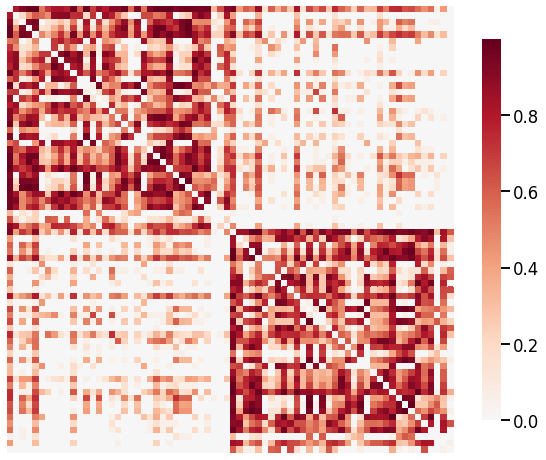

In [11]:
%matplotlib inline

import matplotlib
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
from graspy.utils import ptr
from graspy.plot import heatmap

def plot_graph(g):
    heatmap(g)
    plt.show()

mat = ptr.pass_to_ranks(np.array(nx.to_numpy_matrix(g1.g)))
plot_graph(mat)

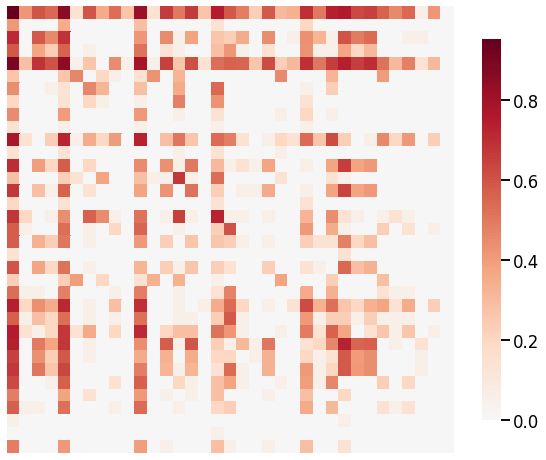

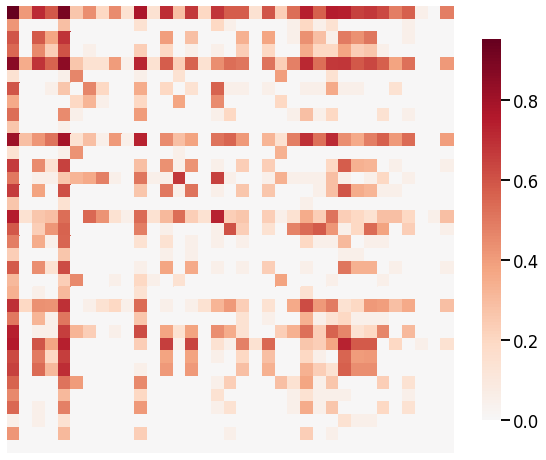

In [12]:
quad_2 = mat[:35, 35:]
np.diagonal(quad_2)
plot_graph(quad_2)


quad_3 = mat[35:, :35]
np.diagonal(quad_3)
plot_graph(quad_3)

In [13]:
np.sum(np.diagonal(quad_2) > 0)/np.sum(np.ones(len(quad_2)))

0.6857142857142857

In [14]:
np.sum(np.diagonal(quad_3) > 0)/np.sum(np.ones(len(quad_3)))

0.6857142857142857